<a href="https://colab.research.google.com/github/JumpNShootMan/TF_MachineLearning/blob/master/TF_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar dataset CIFAR10

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, SimpleRNN, Conv2D, MaxPooling2D, Conv2D
from keras.layers import *
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from random import randrange

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Cargar el Dataset CIFAR10

In [73]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Normalización, Ajuste de forma (reshape) y muestreo de data

(50000, 32, 32, 3)
(50000, 1)


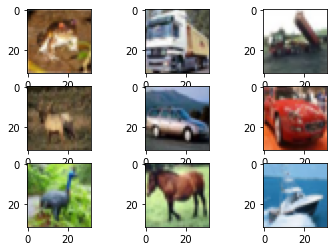

(50000, 1024, 3)
(50000, 1)


In [74]:
print(x_train.shape)
print(y_train.shape)

#ut de untouched, sin tocar
x_train_ut = x_train
x_test_ut = x_test

for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

x_train = x_train.reshape(50000,1024,3)
x_test = x_test.reshape(10000,1024,3)
x_train = x_train/255.0
x_test = x_test/255.0

print(x_train.shape)
print(y_train.shape)

## Modelos Supervisados

### RNN

In [59]:
model1 = Sequential()

#Modelo RNN
model1.add(SimpleRNN(32, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(32)) 
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(32,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(10,activation='softmax'))

opt = tf.keras.optimizers.Adam(lr = 1e-3, decay=1e-5)

model1.compile(loss='sparse_categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

In [60]:
hist1 = model1.fit(x_train,y_train,epochs=3,validation_data=(x_test,y_test))

Epoch 1/3
1563/1563 [==============================] - 624s 399ms/step - loss: 2.2496 - accuracy: 0.1518 - val_loss: 2.1745 - val_accuracy: 0.1786
Epoch 2/3
1563/1563 [==============================] - 635s 406ms/step - loss: 2.1920 - accuracy: 0.1757 - val_loss: 2.1901 - val_accuracy: 0.1843
Epoch 3/3
1563/1563 [==============================] - 643s 412ms/step - loss: 2.2347 - accuracy: 0.1602 - val_loss: 2.1624 - val_accuracy: 0.1926


#### Evaluando RNN

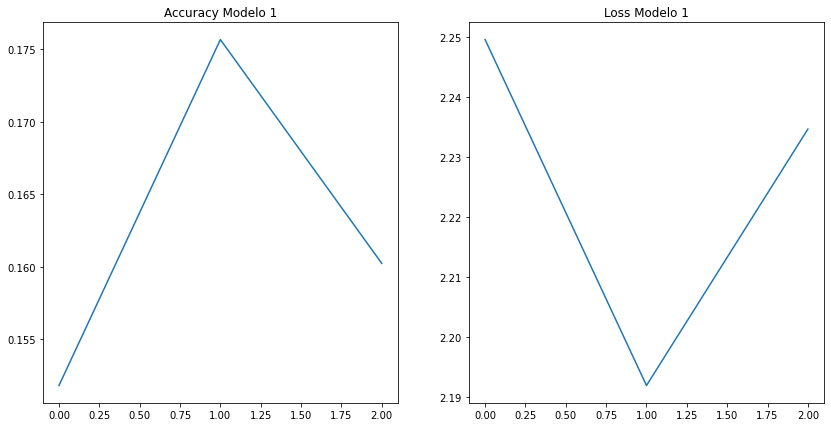

In [61]:
plt.figure(figsize=[14,7])
ax= plt.subplot(1,2,1)
plt.plot(hist1.history['accuracy'])
plt.title('Accuracy Modelo 1')
ax= plt.subplot(1,2,2)
plt.plot(hist1.history['loss'])
plt.title('Loss Modelo 1')
plt.show()

### LSTM

In [62]:
model2 = Sequential()

model2.add(LSTM(32, input_shape=(x_train.shape[1:]), return_sequences=True)) #Sin función de activación ya que se está trabajando con CuDNNLSTM. Se activa cuando no se especifica.
model2.add(Dropout(0.2))
model2.add(LSTM(32))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(32,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10,activation='softmax'))

opt = tf.keras.optimizers.Adam(lr = 1e-3, decay=1e-5)

model2.compile(loss='sparse_categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

In [63]:
hist2 = model2.fit(x_train,y_train,epochs=3,validation_data=(x_test,y_test))

Epoch 1/3
1563/1563 [==============================] - 1202s 769ms/step - loss: 2.2168 - accuracy: 0.1659 - val_loss: 2.2959 - val_accuracy: 0.1051
Epoch 2/3
1563/1563 [==============================] - 1203s 770ms/step - loss: 2.2192 - accuracy: 0.1600 - val_loss: 2.1633 - val_accuracy: 0.2024
Epoch 3/3
1563/1563 [==============================] - 1202s 769ms/step - loss: 2.1578 - accuracy: 0.2014 - val_loss: 2.1369 - val_accuracy: 0.2100


#### Evaluando LSTM

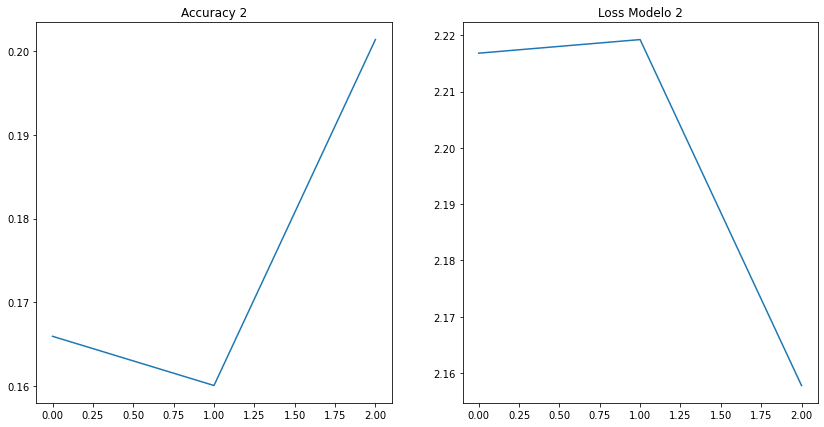

In [64]:
plt.figure(figsize=[14,7])
ax= plt.subplot(1,2,1)
plt.plot(hist2.history['accuracy'])
plt.title('Accuracy 2')
ax= plt.subplot(1,2,2)
plt.plot(hist2.history['loss'])
plt.title('Loss Modelo 2')
plt.show()

## Red Neuronal Convolucional

In [75]:
cnn = Sequential()

#X_test_cnn = x_test_ut
#X_train_cnn = x_train_ut
X_test_cnn = x_test
X_train_cnn = x_train
y_train_cnn = y_train
y_test_cnn = y_test

cnn.add(Conv2D(28, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1))) 
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())         
cnn.add(Dense(64, activation='sigmoid'))
cnn.add(Dropout(rate=0.1)) 
cnn.add(Dense(10, activation='softmax'))
    
cnn.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

cnn.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 28)        280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 28)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6300)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                403264    
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 404,194
Trainable params: 404,194
Non-trainable params: 0
_______________________________________________

In [76]:
# entrenamiento y validación del modelo
n_epochs=10
history = cnn.fit(
    X_train_cnn,
    to_categorical(y_train_cnn),
    epochs=n_epochs,  
    validation_data=(X_test_cnn, to_categorical(y_test_cnn)), 
    batch_size=32
)

Epoch 1/10


ValueError: ignored

In [ ]:
# impresión de precisión, recall y f1-score
y_pred = cnn.predict(X_test_cnn, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_test_cnn, y_pred_cate))

## Modelo No Supervisado KNN